In [180]:
import os
import sys
import spacy
import pandas as pd

from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA

In [232]:
# file_path = "datasets/Restaurant_reviews/Restaurants_Train_v2.csv"
file_path = "datasets/laptops_reviews/laptops-trial.csv"
raw_data = pd.read_csv(file_path)
print(raw_data.head())
reviews = raw_data[["id", "Sentence", "Aspect Term"]]
reviews.head()

     id                                           Sentence    Aspect Term  \
0  2128                         I liked the aluminum body.  aluminum body   
1    81           Lightweight and the screen is beautiful!         screen   
2   353  From the build quality to the performance, eve...  build quality   
3   353  From the build quality to the performance, eve...    performance   
4   655  It was truly a great computer costing less tha...        costing   

   polarity  from  to  
0  positive    12  25  
1  positive    20  26  
2  negative     9  22  
3  negative    30  41  
4  positive    30  37  


,id,Sentence,Aspect Term
0,2128,I liked the aluminum body.,aluminum body
1,81,Lightweight and the screen is beautiful!,screen
2,353,"From the build quality to the performance, eve...",build quality
3,353,"From the build quality to the performance, eve...",performance
4,655,It was truly a great computer costing less tha...,costing


In [233]:
reviews.rename(columns={"id": "id", "Sentence": "text", "Aspect Term": "original_aspects"}, inplace=True)
reviews.columns

/var/folders/mj/qz0vbkcs717cq8rm4j5x5q200000gn/T/ipykernel_73012/4023342088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.rename(columns={"id": "id", "Sentence": "text", "Aspect Term": "original_aspects"}, inplace=True)


Index(['id', 'text', 'original_aspects'], dtype='object')

In [234]:
# list all the aspects of a sentence in one column
results = {}
for row in reviews.itertuples():
    if row.text in results:
        results[row.text].append(row.original_aspects)
    else:
        results[row.text] = [row.original_aspects]

In [235]:
# proper formatting
all_reviews = []
for key, val in results.items():
    all_reviews.append({"review": key, "actual_aspects": list(set(val))}) # getting unique actual aspects

In [236]:
all_reviews[0]

{'review': 'I liked the aluminum body.', 'actual_aspects': ['aluminum body']}

In [7]:
# !python3 -m spacy download en_core_web_lg

In [237]:
nlp = spacy.load("en_core_web_lg")

In [238]:
def apply_extraction(review_body, nlp):
    # review_body = row["Sentence"]
    # review_id = row["id"]
    
    doc = nlp(review_body)
    
    # rule1
    r1_pairs = []
    for token in doc:
        if token.dep_ in ("amod", "advmod") and token.head.pos_ == "NOUN":
            r1_pairs.append((token.head.text, token.text))
            
    # rule2 - Ex: The phone is very lightweight to carry.
    r2_pairs = []
    for token in doc:
        A = ""
        M = ""
        for child in token.children:
            if child.dep_ == "nsubj" and child.pos_ == "NOUN":
                A = child.text
                
            if not M and child.dep_ == "dobj":
                M = child.text
            
            if not M and child.dep_ == "acomp":
                M = child.text
        if A and M:
            r2_pairs.append((A, M))
            
    # rule3
    r3_pairs = []
    # prev_token_pos = ""
    for token in doc:
        A = ""
        M = ""
        for child in token.children:
            if token.pos_ == "NOUN" and child.dep_ == "prep":
                A = token.text
                M = child.text
            # if prev_token_pos != "NOUN" and token.dep_ =="prep" and token.pos_ == "ADP" and child.dep_ == "pobj":
            #     A = child.text
        if A and not M:
            r3_pairs.append((A, M))
        # prev_token_pos = token.pos_

            
    # rule4
    r4_pairs = []
    for token in doc:
        children = token.children
        A = ""
        M = ""
        for child in children:
            if child.dep_ == "nsubjpass":
                A = child.text
                
            if child.dep_ == "advmod":
                M = child.text
        
        if A and M:
            r4_pairs.append((A, M))
            
    # rule5
    r5_pairs = []
    for token in doc:
        children = token.children
        A = ""
        M = ""
        for child in children:
            if child.dep_ == "nsubj":
                A = child.text
                
            if child.dep_ == "cop":
                M = child.text
        
        if A and M:
            r5_pairs.append((A, token.text))
            
    # rule 6 - Ex. I like the lens of the screen.
    r6_pairs = []
    for token in doc:
        A = ""
        M = ""
        if token.pos_ == "VERB":
            for child in token.children:
                if child.dep_ == "nsubj" and child.pos_ == "PRON":
                    continue
                if child.dep_ == "dobj" and child.pos_ == "NOUN":
                    A = child.text
                    M = token.text
        if A and M:
            r6_pairs.append((A, M))
                
                
    # rule 7 - I would like to comment on the camera of this phone.
    A = ""
    M= ""
    r7_pairs=[]
    for i in range(len(doc)-1):
        if doc[i].pos_ == "VERB" and doc[i+1].pos_ == "ADP" and doc[i+1].dep_ == "prep":
            for token in doc[i+1:]:
                for child in token.children:
                    if child.dep_ == "pobj" and child.pos_ == "NOUN":
                        A = child.text
                        M = doc[i].text
                break   
        if A and M:
            r7_pairs.append((A, M))
            break
            
    # rule 8 - It is easy to use
    r8_pairs = []
    for token in doc:
        A = ""
        M = ""
        if token.pos_ == "AUX" and len([child for child in token.children]) >= 2:
            for child in token.children:
                if child.dep_ == "acomp" and child.pos_ == "ADJ":
                    M = child.text
                if child.dep_ == "xcomp" and child.pos_ in ("VERB", "NOUN"):
                    A = child.text
            if A and M:
                r8_pairs.append((A, M))

            
    # aspects = []
    # print(r1_pairs, r2_pairs, r3_pairs, r4_pairs, r5_pairs)
    aspects_pairs = r1_pairs + r2_pairs + r3_pairs + r4_pairs + r5_pairs
    # aspect_dict = {"review_id": review_id, "review_body": review_body, "aspect_pairs": aspects}
    return aspects_pairs

In [10]:
# text = "This phone is a piece of crap."
# doc = nlp(text)
# apply_extraction(doc, nlp)


In [11]:
# all_reviews[0], len(all_reviews)

In [12]:
nchunks = []
for np in nlp("The fried rice is amazing here.").noun_chunks:
    nchunks.append(" ".join([token.text for token in np if not token.is_stop]))
nchunks

['fried rice']

In [239]:
def extract_aspects(pairs):
    """
    extract aspects from (aspects, opinion words) tuple
    """
    aspects = list(set([i[0] for i in pairs]))
    filtered_aspects = []
    for w in aspects:
        # remove pronouns from aspects
        if nlp(w)[0].pos_ != "PRON":
            filtered_aspects.append(w)
    return filtered_aspects

def extract_noun_chunk(review, nlp):
    """
    get noun chunk for review
    """
    nchunks = []
    for np in nlp(review).noun_chunks:
        nchunks.append(" ".join([token.text for token in np if not token.is_stop]))
    return nchunks

def find_noun_phrase(aspects, noun_chunks):
    """
    find corresponding noun phrase for extracted aspect (noun)
    """
    # get noun phrase for the aspects 
    # new_aspects = []
    # for ap in aspects:
    #     new = ""
    #     for nc in noun_chunks:
    #         if ap not in nc.split(" "):
    #             continue
    #         else:
    #             new = nc
    #             break
    #     if new:
    #         new_aspects.append(new)
    #     else:
    #         new_aspects.append(ap)
        
                
    # for small sentences, usually the noun phrases are aspects
    if not aspects and len(noun_chunks) <= 2:
        return [i for i in noun_chunks if i]
    # return new_aspects
    return aspects

In [14]:
# text = "The tables are crammed way too close, the menu is typical of any Italian restaurant, and the wine list is simply overpriced."
text = "We ordered the chicken casserole, but what we got were a few small pieces of chicken, all dark meat and on the bone"
a = extract_aspects(apply_extraction(text, nlp))
nc = extract_noun_chunk(text, nlp)

a
apply_extraction(text, nlp)
# , nc, find_noun_phrase(a, nc)

[('pieces', 'few'), ('pieces', 'small'), ('meat', 'dark')]

In [240]:
import math
from collections import Counter

def find_similarity(l1, l2):
    c1 = Counter(l1)
    c2 = Counter(l2)
    
    # cosine similarity
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

In [241]:
for data in tqdm(all_reviews):
    extracted_aspects = extract_aspects(apply_extraction(data["review"], nlp))
    noun_chunks = extract_noun_chunk(data["review"], nlp)
    data["extracted_aspects"] = find_noun_phrase(extracted_aspects, noun_chunks)
    try:
        data["similarity"] = find_similarity(data["actual_aspects"], data["extracted_aspects"])
    except ZeroDivisionError:
        data["similarity"] = 0
    if data["similarity"] >=0.8:
        data["check"] = True
    else:
        data["check"] = False

100%|█████████████████████████████████████████████| 40/40 [00:08<00:00,  4.83it/s]


In [17]:
all_reviews[0]

{'review': 'But the staff was so horrible to us.',
 'actual_aspects': ['staff'],
 'extracted_aspects': ['staff'],
 'similarity': 1.0,
 'check': True}

In [242]:
def compute_precision(reviews):
    TP = 0
    FP = 0 
    FN = 0
    TN = 0
    for data in reviews:
        # extracted
        for word in data["extracted_aspects"]:
            # and are actual aspects
            if word in data["actual_aspects"]:
                TP += 1
            # not actual aspects
            if word not in data["actual_aspects"]:
                FP += 1
        # not extracted - but are aspects
        for word in data["actual_aspects"]:
            if word not in data["extracted_aspects"]:
                FN += 1
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

In [243]:
precision, recall, f1 = compute_precision(all_reviews)
precision, recall, f1

(0.3695652173913043, 0.3469387755102041, 0.3578947368421052)

In [244]:
pd.DataFrame(all_reviews).to_csv("output/extracted_laptop_aspects_v0.csv")

In [245]:
aspects=[i for a in all_reviews for i in a["extracted_aspects"]]
len(aspects)

46

#### Clustering the extracted aspects

In [246]:
import gensim
from sklearn.manifold import TSNE


def find_optimal_num_cluster(aspect_vectors):
    num_clusters = range(2,7)
    kmeans = [KMeans(n_clusters=i, max_iter=200) for i in num_clusters]
    # try elbow method to get num clusters
    # score = [kmeans[i].fit(aspect_vectors).score(aspect_vectors) for i in range(len(kmeans))]
    # score = [i*-1 for i in score]
    # plt.plot(num_clusters, score)
    # plt.show()
    
    print(kmeans)
    # try silhouete score to get optimal num of clusters
    silhouette_score = [metrics.silhouette_score(aspect_vectors, kmeans[i].fit(aspect_vectors).labels_, metric='euclidean') for i in range(len(kmeans))]
    print("sil score:", silhouette_score)
    # higher silhouete score means denser and better clusters
    best_silhouette_score = 0
    best_num_cluster = 1
    for s in silhouette_score:
        if s > best_silhouette_score:
            best_silhouette_score = s
            best_num_cluster += 1
    return best_num_cluster, best_silhouette_score 
    
def cluster_aspects(aspects):
    aspect_list = [[word] for word in aspects]
    word2vec_model = gensim.models.Word2Vec(aspect_list, min_count=1)
    aspect_vectors = [word2vec_model.wv[word] for word in word2vec_model.wv.index_to_key]

    # find optimal cluster
    num_clusters, best_silhouette_score = find_optimal_num_cluster(aspect_vectors)
    print(f"Optimal num of clusters: {num_clusters}, best silhouette score: {best_silhouette_score}")
    
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans.fit(aspect_vectors)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    print("score: ", kmeans.score(aspect_vectors))
    silhouette_score = metrics.silhouette_score(aspect_vectors, labels, metric='euclidean')
    print("silhouete score: ", silhouette_score)
    for i in range(num_clusters):
        tokens_per_cluster = ""
        top_5_words = word2vec_model.wv.most_similar(positive=[kmeans.cluster_centers_[i]], topn=5)
        for t in top_5_words:
            tokens_per_cluster += f"{t[0]} "
        print(f"Cluster {i}: {tokens_per_cluster}")
    return aspect_vectors, labels

def visualize_clusters(aspects_words, aspect_vectors, labels):
    # tsne = TSNE(n_components=2, random_state=0)
    # val = tsne.fit_transform(np.array(aspect_vectors))
    
    # using PCA to reduce dimension of aspect word vectors
    pca = PCA(n_components=2)
    plot_points = pca.fit_transform(np.array(aspect_vectors))
    x_axis = [i[0] for i in plot_points]
    y_axis = [i[1] for i in plot_points]
    colors = ["r", "b", "c", "y", "m"]
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(x_axis, y_axis, c=[colors[i] for i in labels])
    # plt.scatter(val[:, 0], val[:, 1], c=labels, cmap="rainbow")
    
    for i, txt in enumerate(aspects_words):
        ax.annotate(txt, (x_axis[i], y_axis[i]))
    # return val
    
def get_top_words_from_cluster(unique_aspects, labels):
    aspects_to_labels = dict(zip(unique_aspects, labels))
    labels_w_aspects = defaultdict()
    for a, l in aspects_to_labels.items():
        if l in labels_w_aspects.keys():
            labels_w_aspects[l].append(a)
        else:
            labels_w_aspects[l] = [a]
    return aspects_to_labels, labels_w_aspects

In [247]:
# print("Most representative terms per cluster (based on centroids):")
# for i in range(50):
#     tokens_per_cluster = ""
#     most_representative = word2vec_model.wv.most_similar(positive=[kmeans.cluster_centers_[i]], topn=5)
#     for t in most_representative:
#         tokens_per_cluster += f"{t[0]} "
#     print(f"Cluster {i}: {tokens_per_cluster}")


In [248]:
# !pip install textblob

In [249]:
def clean_aspects(aspects):
    nlp = spacy.load("en_core_web_lg")
    lemmatizer = nlp.get_pipe("lemmatizer")
    
    new_aspects = []
    for word in aspects:
        word = lemmatizer.lemmatize(nlp(word.lower())[0])
        new_aspects.append(word[0])
    return list(set(new_aspects))

[KMeans(max_iter=200, n_clusters=2), KMeans(max_iter=200, n_clusters=3), KMeans(max_iter=200, n_clusters=4), KMeans(max_iter=200, n_clusters=5), KMeans(max_iter=200, n_clusters=6)]
sil score: [0.020938989, 0.014869382, 0.012461058, 0.016980322, 0.015246499]
Optimal num of clusters: 2, best silhouette score: 0.020938988775014877
score:  -0.09756540116419189
silhouete score:  0.01617052
Cluster 0: service cost aluminum game glass 
Cluster 1: twin screen wifi feature software 
Cluster 2: keyboard internet update boot garageband 
Cluster 3: mouse driver background program gaming 
Cluster 4: wireless battery design price tech 


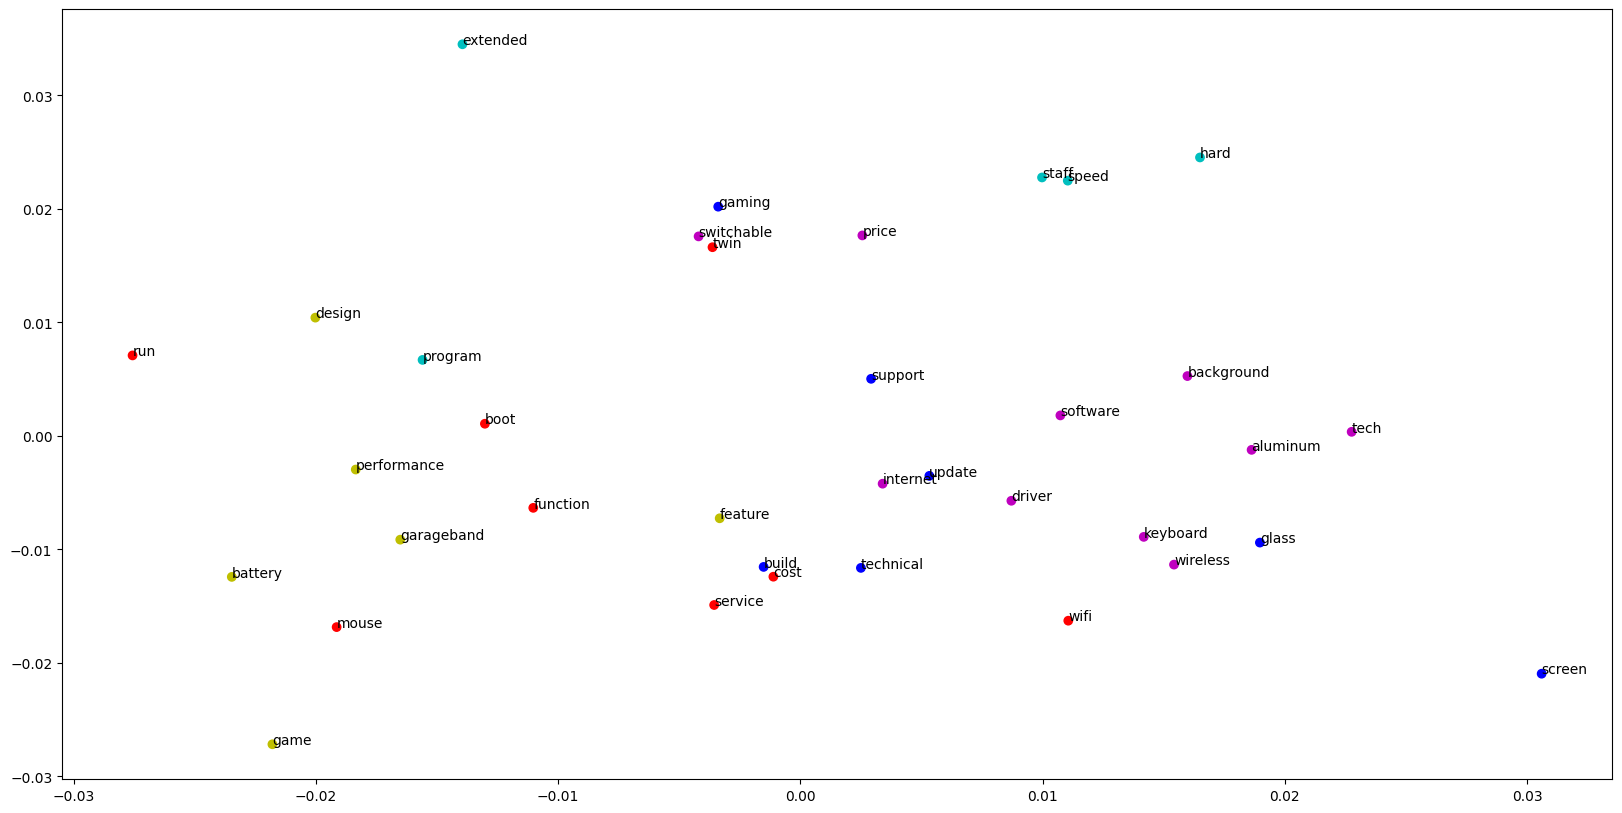

In [250]:
a_aspects=[i for a in all_reviews for i in a["actual_aspects"]]
unique_aspects = clean_aspects(a_aspects)
a_vec, labels = cluster_aspects(unique_aspects)
visualize_clusters(unique_aspects, a_vec, labels)
a_l, l_a = get_top_words_from_cluster(unique_aspects, labels)

[KMeans(max_iter=200, n_clusters=2), KMeans(max_iter=200, n_clusters=3), KMeans(max_iter=200, n_clusters=4), KMeans(max_iter=200, n_clusters=5), KMeans(max_iter=200, n_clusters=6)]
sil score: [0.020895408, 0.015707284, 0.013300118, 0.011134547, 0.012435065]
Optimal num of clusters: 2, best silhouette score: 0.02089540846645832
score:  -0.10777790442245613
silhouete score:  0.017668562
Cluster 0: building price issue laptop function 
Cluster 1: color service pro card sister 
Cluster 2: machine staff support book warranty 
Cluster 3: battery aluminum button laptop issue 
Cluster 4: software design speed opposite screen 


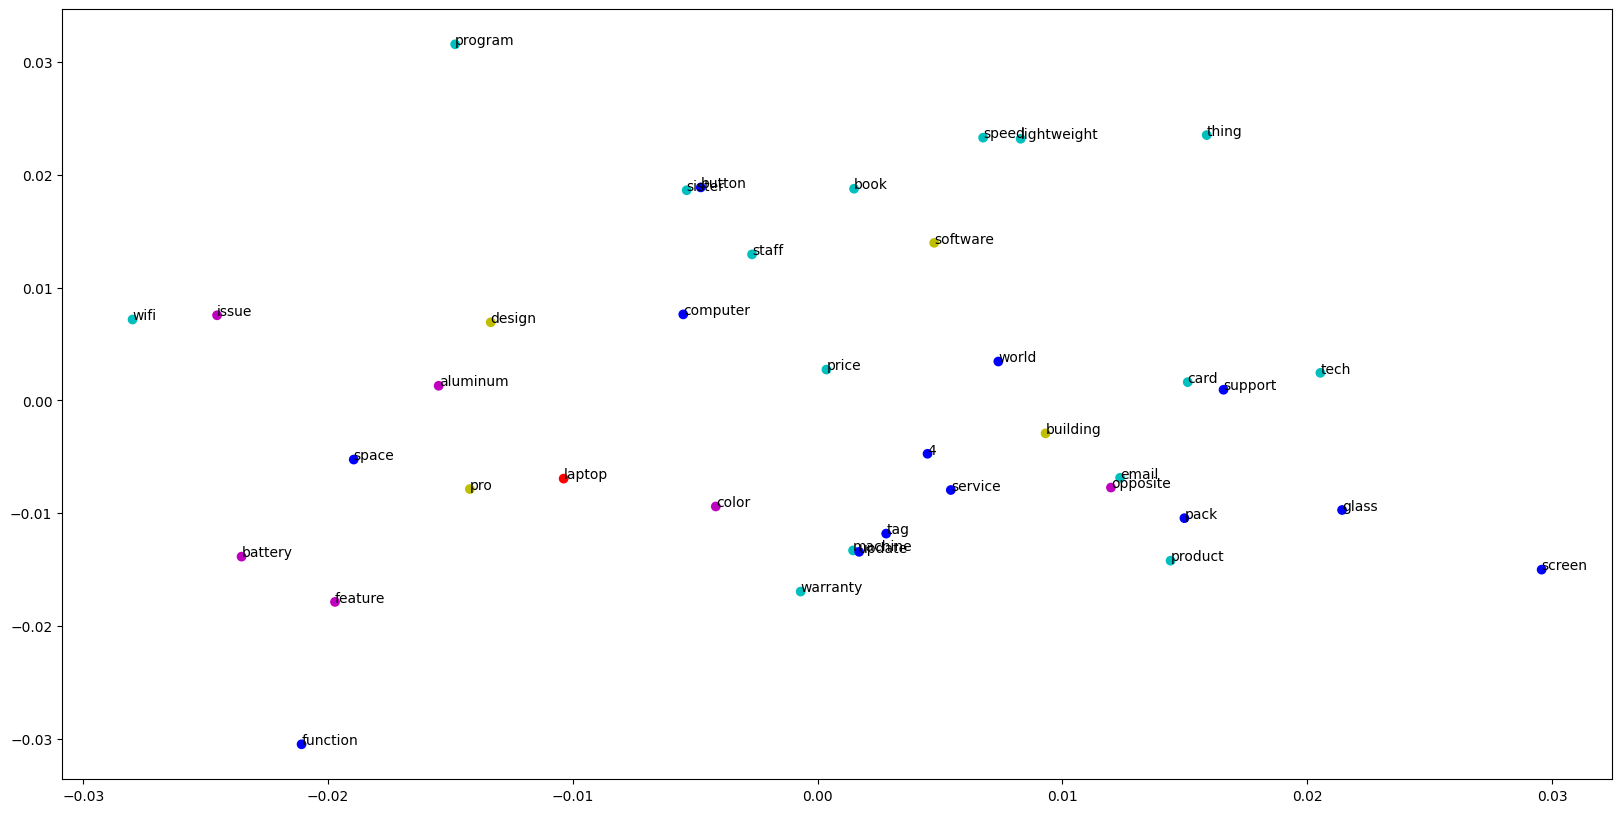

In [251]:
a_aspects=[i for a in all_reviews for i in a["extracted_aspects"]]
unique_aspects = clean_aspects(a_aspects)
a_vec, labels = cluster_aspects(unique_aspects)
visualize_clusters(unique_aspects, a_vec, labels)
a_l, l_a = get_top_words_from_cluster(unique_aspects, labels)

In [123]:
# # map aspects with their cluster labels
# map_aspects = dict(zip(aspects, labels))

# # get all words of a cluster in one
# results = defaultdict()
# for k, val in map_aspects.items():
#     if val in results.keys():
#         results[val].append(k)
#     else:
#         results[val] = [k]
# map_aspects

In [104]:
len(aspect_vectors), len(aspect_vectors[0])

(797, 100)

In [29]:
from collections import defaultdict

aspects_map = defaultdict(int)
for asp in aspects:
    aspects_map[asp] +=1

In [22]:
# # get aspect embeddings using word2vec
# from gensim.models import Word2Vec

# model = Word2Vec(aspects, vector_size=100)
# words = model.wv

# aspect vectors using spacy
asp_vectors = []
for a in aspects:
    token = nlp(a)
    asp_vectors.append(token.vector)

In [23]:
# clustering 
# need to convert the aspects into their vectors/numerical forms
NUM_CLUSTERS=4
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(asp_vectors)
labels = kmeans.labels_

In [24]:
# map aspects with their cluster labels
map_aspects = dict(zip(aspects, labels))

# get all words of a cluster in one
results = defaultdict()
for k, val in map_aspects.items():
    if val in results.keys():
        results[val].append(k)
    else:
        results[val] = [k]

In [37]:
# map_aspects

In [38]:
cluster_map = defaultdict()
cluster_to_asp_map = defaultdict()
for i in range(NUM_CLUSTERS):
    cluster_nouns = [k for k, v in map_aspects.items() if v==i]
    freq_map = {k:v for k,v in aspects_map.items() if k in cluster_nouns}
    freq_map = sorted(freq_map.items(), key=lambda x:x[1], reverse=True)
    cluster_map[i] = freq_map[0][0]
    cluster_to_asp_map[i] = cluster_nouns

In [40]:
# print(cluster_to_asp_map)
print(cluster_map)

defaultdict(None, {0: 'service', 1: 'food', 2: 'restaurant', 3: 'place'})


In [19]:
# import sklearn
# from sklearn.metrics import precision_score, recall_score, f1_score

# y_test=data["actual_aspects"]
# y_pred=data["extracted_aspects"]
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1_score = f1_score(y_test, y_pred)

In [113]:
pd.DataFrame(all_reviews).to_csv("output/extracted_aspects_v3.csv")

In [33]:
d = open("datasets/laptops_reviews/laptop_test_unsupervisedABSA.txt", "r+")

In [87]:
with open("datasets/laptops_reviews/laptop_test_unsupervisedABSA.txt") as f:
    lines = f.readlines()
    f.close()

with open("datasets/laptops_reviews/laptop_test_unsupervisedABSA_v1.txt", "w") as f:
    for line in lines:
        f.write(" ".join(line.strip().split()[3:]))
        f.write("\n")
    f.close()

Check how many of them are correct if we use the rules given

In [16]:
# import os

# os.makedirs("output/")

In [22]:
reviews.head()

,id,text,original_aspects
0,3121,But the staff was so horrible to us.,staff
1,2777,"To be completely fair, the only redeeming fact...",food
2,1634,"The food is uniformly exceptional, with a very...",food
3,1634,"The food is uniformly exceptional, with a very...",kitchen
4,1634,"The food is uniformly exceptional, with a very...",menu


In [9]:
from sklearn import cluster
from collections import defaultdict

In [10]:
NUM_CLUSTERS = 4
aspects = []
for review in review_decomp:
    aspect_pairs = review["aspect_pairs"]
    for noun, adj in aspect_pairs:
        # print(noun, adj)
        aspects.append(noun)
        
unique_aspects = list(set(aspects))

In [11]:
len(unique_aspects)

64

In [20]:
aspects_map = defaultdict(int)
for asp in aspects:
    aspects_map[asp] += 1

In [24]:
asp_vectors = []
for aspect in unique_aspects:
    token = nlp(aspect)
    asp_vectors.append(token.vector)
    
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(asp_vectors)
labels = kmeans.labels_
asp_to_cluster_map = dict(zip(unique_aspects, labels))
print(asp_to_cluster_map)

{'benches': 2, 'food': 0, 'questions': 2, 'taste': 0, 'prices': 2, 'place': 2, 'concept': 2, 'setting': 2, 'spot': 0, 'rice': 0, 'above': 2, 'dinner': 0, 'selection': 2, 'dishes': 0, 'experience': 2, 'you': 3, 'decoration': 2, 'Faan': 0, 'I': 3, 'He': 1, 'variety': 2, 'mussels': 0, 'staff': 2, 'which': 2, 'lovers': 0, 'bagels': 0, 'decor': 0, 'choices': 2, 'desert': 0, 'we': 3, 'vibe': 0, 'money': 2, 'size': 2, 'quantity': 2, 'menu': 0, 'perks': 0, 'wine': 0, 'floor': 2, 'pizza': 0, 'broth': 0, 'deficiencies': 2, 'factor': 2, 'people': 2, 'list': 2, 'favorite': 0, 'restaurants': 0, 'price': 2, 'me': 3, 'owner': 0, 'all': 2, 'Bagels': 0, 'They': 2, 'service': 2, 'design': 2, 'meal': 0, 'stomach': 0, 'waiters': 0, 'seats': 2, 'kitchen': 0, 'atmosphere': 2, 'dressing': 2, 'temperatures': 2, 'It': 2, 'texture': 2}


In [28]:
cluster_map = defaultdict()
cluster_to_asp_map = defaultdict()
for i in range(NUM_CLUSTERS):
    cluster_nouns = [k for k, v in asp_to_cluster_map.items() if v==i]
    freq_map = {k:v for k, v in aspects_map.items() if k in cluster_nouns}
    freq_map = sorted(freq_map.items(), key=lambda x: x[1], reverse=True)
    cluster_map[i] = freq_map[0][0]
    cluster_to_asp_map[i] = cluster_nouns

In [30]:
cluster_to_asp_map

defaultdict(None,
            {0: ['food',
              'taste',
              'spot',
              'rice',
              'dinner',
              'dishes',
              'Faan',
              'mussels',
              'lovers',
              'bagels',
              'decor',
              'desert',
              'vibe',
              'menu',
              'perks',
              'wine',
              'pizza',
              'broth',
              'favorite',
              'restaurants',
              'owner',
              'Bagels',
              'meal',
              'stomach',
              'waiters',
              'kitchen'],
             1: ['He'],
             2: ['benches',
              'questions',
              'prices',
              'place',
              'concept',
              'setting',
              'above',
              'selection',
              'experience',
              'decoration',
              'variety',
              'staff',
              'which',
            